# GraphRAG vs Regular RAG Demo

This notebook demonstrates the difference between GraphRAG and regular RAG for movie recommendations using a knowledge graph built from TMDB data.

## What you'll see:
1. **Data Collection**: Fetch 15 popular Tamil cinema actors and their movies from TMDB
2. **Knowledge Graph**: Build a Neo4j graph with Tamil movies, actors, directors, and genres
3. **Regular RAG**: Use vector embeddings for similarity search
4. **GraphRAG**: Use graph traversal and relationships for recommendations
5. **Comparison**: Side-by-side analysis of both approaches


## Setup and Imports


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('src')

# Force reload of the module to avoid cached versions
if 'utils.graphrag_helpers' in sys.modules:
    import importlib
    importlib.reload(sys.modules['utils.graphrag_helpers'])

from utils.graphrag_helpers import (
    TMDBClient, Neo4jGraphBuilder, SimpleRAG, GraphRAG,
    visualize_graph_sample, compare_rag_vs_graphrag
)

# Load environment variables
load_dotenv()

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful!")


✅ All imports successful!


## 1. Data Collection from TMDB API (Tamil Cinema)


In [2]:
# Initialize TMDB client
tmdb_api_key = os.getenv('TMDB_API_KEY')
if not tmdb_api_key:
    print("❌ Please set TMDB_API_KEY in your .env file")
    print("Get your API key from: https://www.themoviedb.org/settings/api")
else:
    tmdb_client = TMDBClient(tmdb_api_key)
    print("✅ TMDB client initialized")
    
    # Fetch artists and movies data
    df = tmdb_client.fetch_artists_and_movies(num_artists=15)
    
    print(f"📊 Fetched {len(df)} Tamil movie records from {df['person_name'].nunique()} Tamil cinema actors")
    print(f"🎬 Movies span {df['movie_release_date'].str[:4].nunique()} different years")
    print(f"🎭 Genres: {df['movie_genres'].explode().nunique()} unique genres")
    print(f"🎭 Languages: {df['original_language'].nunique()} unique languages (mostly Tamil)")
    
    # Display sample data
    print("\n📋 Sample data:")
    display(df[['person_name', 'movie_title', 'movie_genres', 'movie_vote_average']].head())


✅ TMDB client initialized
Fetching 15 popular Tamil cinema actors and their movies...
📊 Fetched 33 Tamil movie records from 9 Tamil cinema actors
🎬 Movies span 19 different years
🎭 Genres: 12 unique genres
🎭 Languages: 5 unique languages (mostly Tamil)

📋 Sample data:


,person_name,movie_title,movie_genres,movie_vote_average
0,Rajinikanth,Sivaji: The Boss,"[Action, Drama]",7.038
1,Rajinikanth,Ra.One,"[Adventure, Action, Science Fiction]",5.695
2,Rajinikanth,Kuselan,[Drama],5.000
3,Rajinikanth,Vettaiyan,"[Action, Crime, Drama]",6.167
4,Rajinikanth,Bloodstone,"[Action, Adventure, Comedy]",4.300


In [3]:
print('df: ', df)

df:      person_id      person_name person_known_for  movie_id  \
0       91555      Rajinikanth           Acting     24049   
1       91555      Rajinikanth           Acting     41517   
2       91555      Rajinikanth           Acting     12274   
3       91555      Rajinikanth           Acting   1093966   
4       91555      Rajinikanth           Acting     42248   
5       93193     Kamal Haasan           Acting     30344   
6       93193     Kamal Haasan           Acting     31521   
7       93193     Kamal Haasan           Acting     25121   
8       93193     Kamal Haasan           Acting     26910   
9       93193     Kamal Haasan           Acting     14445   
10      91547            Vijay           Acting     24383   
11      91547            Vijay           Acting     63634   
12      91547            Vijay           Acting     63636   
13      91547            Vijay           Acting     63648   
14      91547            Vijay           Acting     63644   
15    2417851      

## 2. Build Knowledge Graph in Neo4j


In [4]:
# Initialize Neo4j connection
neo4j_uri = os.getenv('NEO4J_URI', 'bolt://localhost:7687')
neo4j_user = os.getenv('NEO4J_USER', 'neo4j')
neo4j_password = os.getenv('NEO4J_PASSWORD', 'movies123')

try:
    graph_builder = Neo4jGraphBuilder(neo4j_uri, neo4j_user, neo4j_password)
    print("✅ Connected to Neo4j")
    
    # Clear existing data
    graph_builder.clear_database()
    print("🗑️ Cleared existing data")
    
    # Build graph
    if 'df' in locals():
        graph_builder.build_graph(df)
        
        # Get graph statistics
        stats = graph_builder.get_graph_stats()
        print("\n📈 Graph Statistics:")
        for key, value in stats.items():
            print(f"  {key}: {value}")
    
    graph_builder.close()
    
except Exception as e:
    print(f"❌ Error building knowledge graph: {e}")
    print("💡 Make sure Neo4j is running: docker-compose up neo4j")


✅ Connected to Neo4j
🗑️ Cleared existing data
Building knowledge graph in Neo4j...
Knowledge graph built successfully!

📈 Graph Statistics:
  Person_count: 41
  Movie_count: 33
  Genre_count: 12
  ACTED_IN_count: 33
  HAS_GENRE_count: 71
  DIRECTED_count: 33


## 3. Visualize the Knowledge Graph


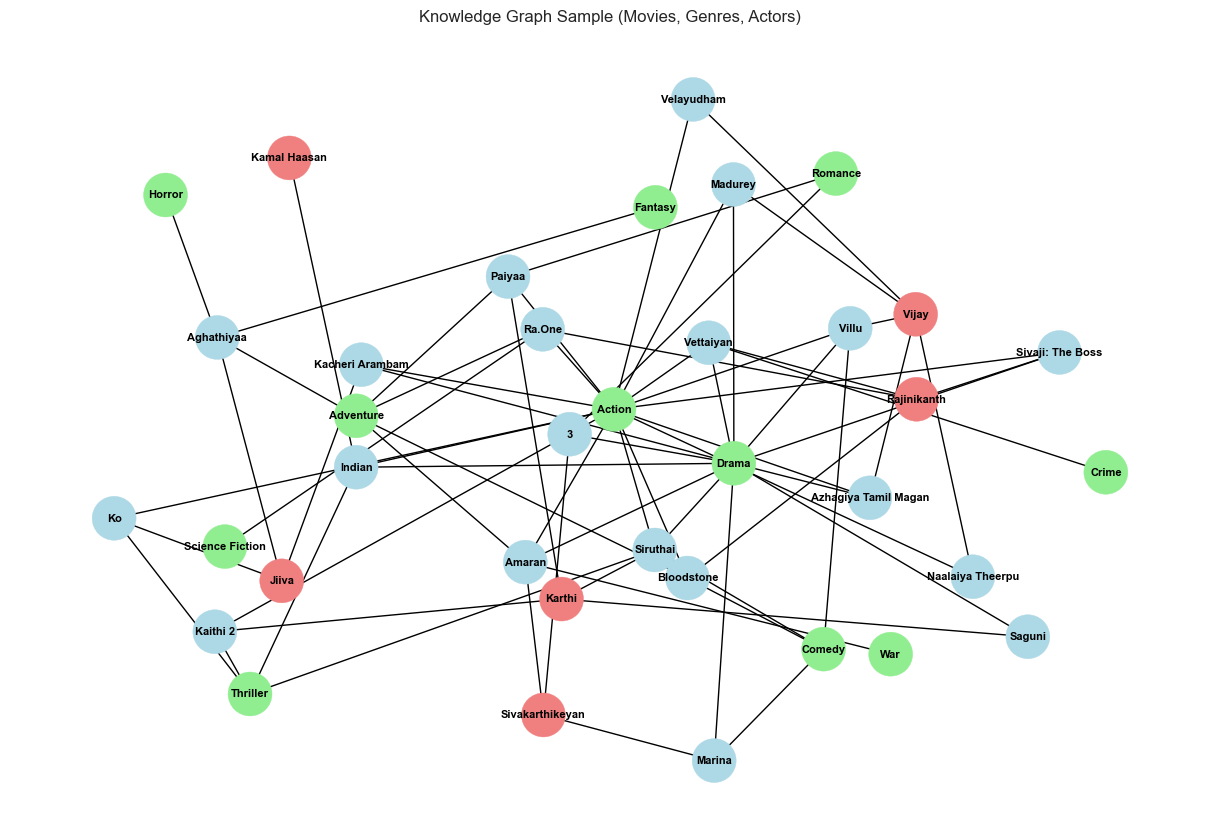

🎨 Graph visualization complete!


In [9]:
# Visualize a sample of the graph
try:
    # visualize_graph_sample(neo4j_uri, neo4j_user, neo4j_password, limit=15)
    visualize_graph_sample(neo4j_uri, neo4j_user, neo4j_password)
    print("🎨 Graph visualization complete!")
except Exception as e:
    print(f"❌ Error visualizing graph: {e}")


## 4. Regular RAG Implementation


In [6]:
# Initialize RAG system
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    print("❌ Please set OPENAI_API_KEY in your .env file")
    print("Get your API key from: https://platform.openai.com/api-keys")
else:
    print("✅ OpenAI API key found")
    
    if 'df' in locals():
        # Initialize RAG
        rag = SimpleRAG(openai_api_key)
        rag.add_documents(df)
        print("✅ RAG system initialized with vector embeddings")
        
        # Test search
        test_query = "action movies with great actors"
        search_results = rag.search(test_query, top_k=3)
        
        print(f"\n🔍 Search results for '{test_query}':")
        for i, result in enumerate(search_results, 1):
            print(f"{i}. {result['document']['movie_title']} (similarity: {result['similarity']:.3f})")
    else:
        print("❌ No data available for RAG")


✅ OpenAI API key found
Building vector embeddings for RAG...
✅ RAG system initialized with vector embeddings

🔍 Search results for 'action movies with great actors':
1. Ra.One (similarity: 0.583)
2. Vettaiyan (similarity: 0.440)
3. Michael Madana Kama Rajan (similarity: 0.431)


## 5. GraphRAG Implementation


In [7]:
# Initialize GraphRAG system
if 'openai_api_key' in locals() and openai_api_key:
    try:
        graphrag = GraphRAG(neo4j_uri, neo4j_user, neo4j_password, openai_api_key)
        print("✅ GraphRAG system initialized")
        
        # Test graph context extraction
        test_query = "action movies with great actors"
        context = graphrag.extract_subgraph_context(test_query)
        
        print(f"\n🕸️ Graph context for '{test_query}':")
        print(context[:500] + "..." if len(context) > 500 else context)
        
        graphrag.close()
        
    except Exception as e:
        print(f"❌ Error initializing GraphRAG: {e}")
else:
    print("❌ OpenAI API key not available")


✅ GraphRAG system initialized

🕸️ Graph context for 'action movies with great actors':

                Movie: Amaran
                Overview: A heroic true story of Major Mukund Varadarajan, an Indian Army officer who displayed extraordinary bravery during a counterterrorism mission in Kashmir’s Shopian district. The film captures his courage in protecting his nation and the devotion of his wife Indhu Rebecaa Varghese.
                Genres: Action
                Actors: Sivakarthikeyan
                Directors: Rajkumar Periasamy
                Rating: 7.388
               ...


## 6. Side-by-Side Comparison: RAG vs GraphRAG


In [8]:
# Compare RAG vs GraphRAG
if 'df' in locals() and 'openai_api_key' in locals() and openai_api_key:
    
    # Test queries
    test_queries = [
        "Recommend action movies with great actors",
        "I want comedy movies with good ratings",
        "Show me drama movies from talented directors"
    ]
    
    for query in test_queries:
        print(f"\n{'='*80}")
        print(f"QUERY: {query}")
        print(f"{'='*80}")
        
        try:
            results = compare_rag_vs_graphrag(
                query, df, neo4j_uri, neo4j_user, neo4j_password, openai_api_key
            )
        except Exception as e:
            print(f"❌ Error in comparison: {e}")
            continue
        
        print("\n" + "="*80)
        
else:
    print("❌ Missing data or API key for comparison")



QUERY: Recommend action movies with great actors
RAG vs GraphRAG Comparison
Query: Recommend action movies with great actors

Building vector embeddings for RAG...
🔍 Regular RAG Recommendations:
----------------------------------------
🔍 RAG found 5 relevant movies:
  1. Ra.One (similarity: 0.544)
  2. Vaa Vaathiyaar (similarity: 0.401)
  3. Vettaiyan (similarity: 0.400)
  4. Azhagiya Tamil Magan (similarity: 0.393)
  5. Michael Madana Kama Rajan (similarity: 0.392)
Based on the provided context of action movies with great actors, here are the top 5 movie recommendations:

1. **Ra.One**
   - Overview: When the titular antagonist of an action game takes on physical form, it's up to the game's less powerful protagonist to save the world.
   - Cast: Shah Rukh Khan, Arjun Rampal, Kareena Kapoor Khan, Armaan Verma, Tom Wu
   - Director: Anubhav Sinha
   - Release Date: 2011-10-24
   - Rating: 5.695

2. **Vettaiyan**
   - Overview: A sought-after Supercop gets caught in a series of unexpect

## 7. Analysis and Summary

### Key Differences Between RAG and GraphRAG:

| Aspect | Regular RAG | GraphRAG |
|--------|-------------|----------|
| **Data Structure** | Flat text documents | Graph with relationships |
| **Search Method** | Vector similarity | Graph traversal |
| **Context** | Text-based | Relationship-based |
| **Reasoning** | Surface-level similarity | Deep relationship analysis |
| **Scalability** | Good for large text | Better for complex relationships |

### Whats Demonstrated:
1. **Data Collection**: Fetched real movie data from TMDB API
2. **Knowledge Graph**: Built a Neo4j graph with movies, actors, directors, and genres
3. **Regular RAG**: Used vector embeddings for similarity search
4. **GraphRAG**: Used graph traversal and relationships for recommendations
5. **Comparison**: Showed how GraphRAG provides more contextual recommendations

### Next Steps / Improvements:
- Add more complex graph queries
- Implement multi-hop reasoning
- Scale to larger datasets
- Add user preferences and feedback
